# Functions and imports

In [1]:
%reload_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
from routes import config
from routes.network import Network
from routes.peers_view import PeersView
from routes.user import User
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import threading
import time

In [2]:
def init_experiment(conf=config.default):
    address_book = PeersView(conf)
    net = Network()

    n_devices = 0
    users = [None] * conf['n_users']
    for i in range(conf['n_users']):
        users[i] = User(address_book, net, conf)
        n_devices += users[i].n_devices

    #print("initialized {} users and {} devices".format(conf['n_users'], n_devices))
    return users, net, address_book

def perform_round(conf, users, address_book_df=None, devices_view_df=None,
                  current_round=None, sleep=False):
    t_start = datetime.now()
    #print("Round #{}/{} at {}".format(t+1, conf['n_rounds'], datetime.now().time()))
    for user in users:
        user.act()
    for user in users:
        user.rps()
        
        if devices_view_df is not None:
            for d in user.devices:
                devices_view_df = devices_view_df.append(
                    d.peers_view.snapshot({'round': t}))
    if address_book_df is not None:
        address_book_df = address_book_df.append(
            address_book.snapshot({'round': t}))
    
    elapsed = conf['period']
    if sleep:
        elapsed = datetime.now() - t_start
        if elapsed > conf['period']:
            print("We are running overtime! Took {}, conf['period']={}".format(
                elapsed, conf['period']))
        elif current_round != conf['n_rounds'] - 1:
            #print("Sleeping", conf['period'] - elapsed)
            time.sleep((conf['period'] - elapsed).total_seconds())
    
    if current_round is None:
        current_round = 0
    else:
        current_round += 1
        
    return current_round, elapsed, address_book_df, devices_view_df

def get_online_device(users):
    user = random.choice(users)
    while not user.has_online_devices():
        user = random.choice(users)
    return user.get_online_device()
def get_devices_pair(users):
    d1, d2 = get_online_device(users), get_online_device(users)
    while d1.owner == d2.owner:
        d2 = get_online_device(users)
    return d1, d2

def build_route(d1, d2, n_layers):
    route = [None] * n_layers
    route[:n_layers//2] = d1.build_route(role='sender')
    route[n_layers//2:] = d1.build_route(role='receiver')
    return route

# Experiment

In [3]:
# Subclassing Thread to be able to retrieve dfs from the caller 
class Experiment(threading.Thread):
    def __init__(self, conf, experiment_id, n_routes, n_rounds):
        super(Experiment, self).__init__()
        
        self.conf = conf
        self.experiment_id = experiment_id
        self.n_routes = n_routes
        self.n_rounds = n_rounds
        self.period = conf['period']
        
        self.routes_df, self.layers_df = pd.DataFrame(), pd.DataFrame()
        
    def run(self):
        self.layers_df, self.routes_df, self.period = \
            run_experiment(self.conf, self.experiment_id, 
                          self.n_routes, self.n_rounds)
                
def run_experiment(conf, experiment_id, n_routes, n_rounds_since_route):
    layers_df, routes_df = pd.DataFrame(), pd.DataFrame()
    users, net, address_book = init_experiment(conf)
    # perform a first round to pick devices
    _, period, _, _ = perform_round(conf, users)
    conf['period'] = max(conf['period'], period)

    # Putting (d1, d2) in a set to avoid duplicates
    devices_pairs = set()
    while len(devices_pairs) < n_routes:
        d1, d2 = get_devices_pair(users)
        devices_pairs.add((d1, d2))

    routes = [build_route(d1, d2, conf['n_layers']) 
                  for (d1, d2) in devices_pairs]

    for route_id, route in enumerate(routes):
        for layer_id, layer in enumerate(route):
            #print(layer)
            p_failure = 1
            if len(layer) > 0:
                p_failure = (1 - layer['p']).prod()
            layers_df = layers_df.append(pd.Series({
                'experiment_id': experiment_id,
                'route_id': route_id,
                'layer_id': layer_id,
                'n_layers': conf['n_layers'],
                'layer_threshold': conf['layer_threshold'],
                'layer_size': len(layer),
                'p_failure': p_failure
            }), ignore_index=True)

    for t in range(1, n_rounds_since_route+1):
#         t_start = time.perf_counter()
        _, period, _, _ = perform_round(conf, users, 
                      current_round=t-1, sleep=True)
        conf['period'] = max(conf['period'], period)
#         t_end = time.perf_counter()
#         print("A round lasted {}".format(timedelta(seconds=t_end - t_start)))

        for route_id, route in enumerate(routes):
            success = False
            empty_layer = any([len(layer) == 0 for layer in route])
            if not empty_layer:
                success = all([
                    any([net.get_device(addr).is_online 
                        for addr in layer['addr']])
                    for layer in route])

            routes_df = routes_df.append(pd.Series({
                'experiment_id': experiment_id,
                'route_id': route_id,
                'n_layers': conf['n_layers'],
                'layer_threshold': conf['layer_threshold'],
                't': t,
                'success': success
            }), ignore_index=True)
    
    return layers_df, routes_df, period

routes_df = pd.DataFrame()
layers_df = pd.DataFrame()

N_ROUTES_PER_EXPERIMENT = 20
N_ROUNDS_SINCE_ROUTE = 10
N_LAYERS = [3, 5, 7]
LAYER_THRESHOLD = [0.1, 0.01, 0.001, 0.0001]
N_EXPERIMENTS = 10
INITIAL_PERIOD = timedelta(seconds=12)
period = INITIAL_PERIOD
total_n_experiments = len(N_LAYERS) * len(LAYER_THRESHOLD)

t_start = time.perf_counter()
total_experiment_id = 1
for n_layers in N_LAYERS:
    for layer_threshold in LAYER_THRESHOLD:
        experiments = [None] * N_EXPERIMENTS
        for experiment_id in range(N_EXPERIMENTS):
            n_users = n_layers * 5
            conf = {
                'gossip_size': 10 * n_layers,
                'layer_threshold': layer_threshold,
                'minimum_node_availability': 0,
                'n_layers': n_layers,  # must be odd
                'n_rounds': N_ROUNDS_SINCE_ROUTE + 1,
                'n_users': n_layers * 5,
                'period': period,
            }
            
#             layers, routes = run_experiment(conf, experiment_id, 
#                                            N_ROUTES_PER_EXPERIMENT, 
#                                            N_ROUNDS_SINCE_ROUTE)
            
            experiments[experiment_id] = Experiment(conf, experiment_id, 
                           N_ROUTES_PER_EXPERIMENT, 
                           N_ROUNDS_SINCE_ROUTE)
            experiments[experiment_id].start()
        
        for experiment in experiments:
            experiment.join()
            layers_df = layers_df.append(experiment.layers_df, ignore_index=True)
            routes_df = routes_df.append(experiment.routes_df, ignore_index=True)
            # not sure about this
            period = max(period, experiment.period)
            
        time_spent = timedelta(seconds=time.perf_counter() - t_start)
        print("[{}] Experiment {}/{} done.".format(
            time_spent, total_experiment_id, total_n_experiments))
        total_experiment_id += 1

[0:02:19.520065] Experiment 1/12 done.
[0:04:40.996786] Experiment 2/12 done.
[0:07:05.520952] Experiment 3/12 done.
[0:09:33.365388] Experiment 4/12 done.
[0:12:00.238650] Experiment 5/12 done.
[0:14:33.094441] Experiment 6/12 done.
[0:17:12.498677] Experiment 7/12 done.
[0:19:58.517909] Experiment 8/12 done.
[0:22:35.742974] Experiment 9/12 done.
[0:25:23.996773] Experiment 10/12 done.
[0:28:20.679897] Experiment 11/12 done.
[0:31:26.961688] Experiment 12/12 done.


# Interpretation of results

In [3]:
layers_df, routes_df = \
    pd.read_csv("outputs/experiment/layers_df.csv"),\
    pd.read_csv("outputs/experiment/routes_df.csv")
N_LAYERS = layers_df['n_layers'].unique()
LAYER_THRESHOLD = layers_df['layer_threshold'].unique()
N_EXPERIMENTS = len(layers_df['experiment_id'].unique())
N_ROUNDS = len(routes_df['t'].unique())

## number of devices per layer = f(layer threshold)

In [15]:
# median absolute deviation 
def mad(x):
    return np.median(np.absolute(x - np.median(x)))

data_median = np.empty((len(LAYER_THRESHOLD), 3), dtype=np.float64)
data_mean = np.empty((len(LAYER_THRESHOLD), 3), dtype=np.float64)
for i, layer_threshold in enumerate(LAYER_THRESHOLD):
    df = layers_df[layers_df['layer_threshold'] == layer_threshold]
    
    data_median[i] = [layer_threshold, df['layer_size'].median(), mad(df['layer_size'])]
    data_mean[i] = [layer_threshold, df['layer_size'].mean(), df['layer_size'].std()]

print(data_median)
print(data_mean)

[[  1.00000000e-01   2.00000000e+00   0.00000000e+00]
 [  1.00000000e-02   3.00000000e+00   1.00000000e+00]
 [  1.00000000e-03   5.00000000e+00   1.00000000e+00]
 [  1.00000000e-04   6.00000000e+00   1.00000000e+00]]
[[  1.00000000e-01   2.02200000e+00   7.38262156e-01]
 [  1.00000000e-02   3.41666667e+00   9.74699391e-01]
 [  1.00000000e-03   4.79133333e+00   1.18642070e+00]
 [  1.00000000e-04   6.17800000e+00   1.44741644e+00]]


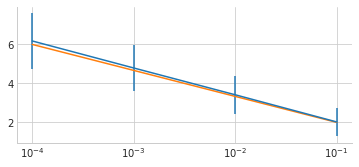

In [69]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.despine()
sns.set_style("whitegrid")

x = [0.0001, 0.001, 0.01, 0.1]
y = -4/3 * np.log10(x) + 2/3

#ax.plot(data_mean[:, 0], data_mean[:, 1])
ax.errorbar(data_mean[:, 0], data_mean[:, 1], yerr=data_mean[:, 2])
ax.plot(x, y)

#ax.set_xscale('log')
ax.semilogx()

plt.show()

## Routes success rate

In [39]:
data = pd.DataFrame()

for layer_threshold in LAYER_THRESHOLD:
    for n_layers in N_LAYERS:
        for t in range(1, N_ROUNDS+1):
            df = routes_df[(routes_df['layer_threshold'] == layer_threshold) &
                           (routes_df['n_layers'] == n_layers) & 
                           (routes_df['t'] == t)]

            data = data.append(pd.Series({
                'layer_threshold': layer_threshold,
                'n_layers': n_layers,
                't': t,
                'success_rate': df['success'].mean(),
                'std': df['success'].std(),
            }), ignore_index=True)
data

,layer_threshold,n_layers,std,success_rate,t
0,0.1000,3.0,0.352984,0.855,1.0
1,0.1000,3.0,0.367526,0.840,2.0
2,0.1000,3.0,0.362813,0.845,3.0
3,0.1000,3.0,0.376575,0.830,4.0
4,0.1000,3.0,0.376575,0.830,5.0
5,0.1000,3.0,0.376575,0.830,6.0
6,0.1000,3.0,0.393285,0.810,7.0
7,0.1000,3.0,0.331549,0.875,8.0
8,0.1000,3.0,0.357967,0.850,9.0
9,0.1000,3.0,0.300753,0.900,10.0


### success rate = f(t+i)

In [40]:
LAYER_THRESHOLD_COL = "$\\theta$"
data2 = data.rename(columns={
    'layer_threshold': LAYER_THRESHOLD_COL,
    'n_layers': 'L',
    'success_rate': 'success rate'})

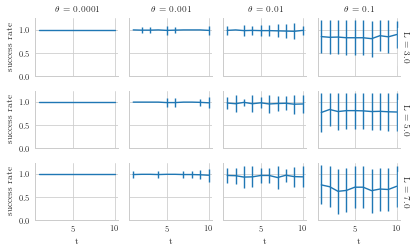

In [49]:
sns.set_style("whitegrid")
sns.set_context('paper')
sns.set(font='serif')
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

g = sns.FacetGrid(data2, col=LAYER_THRESHOLD_COL,  row="L", despine=True, margin_titles=True, size=1.2, aspect=1.2, ylim=(0, 1.25), palette="Grays")
g = g.map_dataframe(plt.errorbar, "t", "success rate", "std")
#plt.suptitle("Error rate as a function of the time after route establishment")
plt.savefig("outputs/success_rate_vs_t_small.svg")

plt.show()

## success rate = f(layer threshold)

In [34]:
TIMES = [1, 5, 10]
this_data = data[data['t'].isin(TIMES)]

sns.set_style("whitegrid")
g = sns.FacetGrid(this_data, col="t",  row="n_layers", despine=True, margin_titles=True)
g.set(xscale="log")
g = g.map_dataframe(plt.errorbar, "layer_threshold", "success_rate", "std")
#plt.suptitle("Error rate as a function of the time after route establishment")
plt.savefig("outputs/success_rate_vs_layer_threshold.svg")
plt.show()

KeyError: 'n_layers'

## success rate = f(layer threshold)

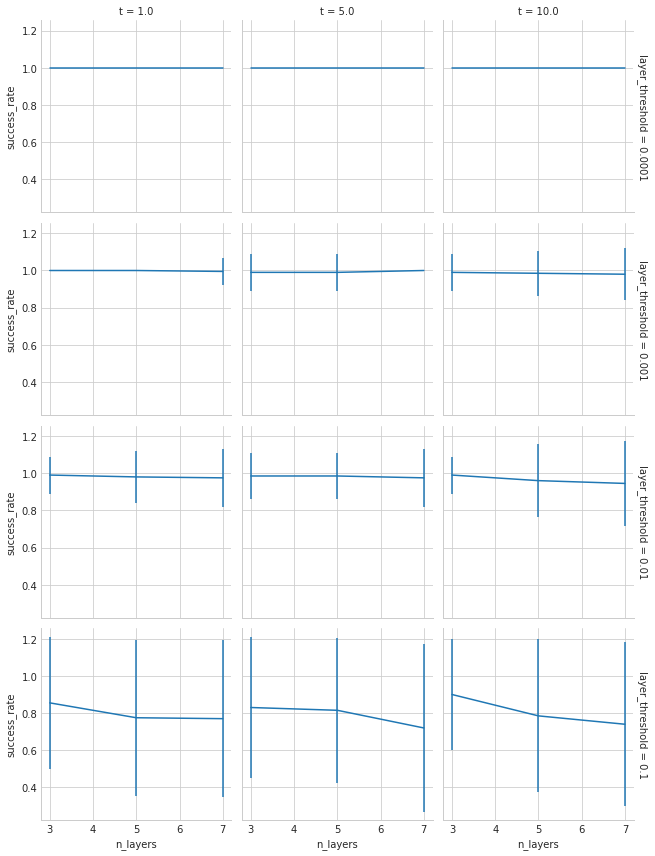

In [62]:
TIMES = [1, 5, 10]
this_data = data[data['t'].isin(TIMES)]

sns.set_style("whitegrid")
g = sns.FacetGrid(this_data, col="t",  row="layer_threshold", despine=True, margin_titles=True)
#g.set(xscale="log")
g = g.map_dataframe(plt.errorbar, "n_layers", "success_rate", "std")
#plt.suptitle("Error rate as a function of the time after route establishment")
plt.savefig("outputs/success_rate_vs_n_layers.svg")
plt.show()

# Test of PeersView

In [116]:
addresses = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
N = 20
EXPIRATION_PERIOD = timedelta(seconds=1)
print("Expiration period:", EXPIRATION_PERIOD)

address_book = PeersView(expiration_period=EXPIRATION_PERIOD)

for _ in range(N):
    connected = random.sample(addresses, k=random.randint(1, int(2 * len(addresses) / 3)))
    print("Time {}: connected = {}".format(datetime.now().time(), connected))
    
    for d in connected:
        address_book.put(datetime.now(), d, 0.8)
        time.sleep(0.1)
    
    print("Address book:")
    print(address_book.view)
    print()

Expiration period: 0:00:01
Time 00:01:59.105652: connected = ['g']


TypeError: put() missing 1 required positional argument: 'p'